In [1]:
#pip 24.0
#Phython v 3.11.5 
import math
#import scipy.stats as st
from scipy.integrate import quad
from scipy.special import gammainc
from scipy.optimize import fmin
from scipy.linalg import ldl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('expand_frame_repr', False)

#import naginterfaces.library as ni
from naginterfaces.library.quad import dim1_gauss_recm
from naginterfaces.library.quad import dim1_gauss_wrec
from naginterfaces.library.matop import real_modified_cholesky
from naginterfaces.library.matop import real_mod_chol_perturbed_a
from naginterfaces.library.blas import dlansy
from naginterfaces.library.machine import precision
from __future__ import division

In [2]:
####### FUNCTIONS #######

def round_mn(m, N):
    """ The value of m is rounded up to the next integer,
    the value of n is chosen such that n*m is as close as possible to N."""
    m = math.ceil(m) 
    n = N/m 
    if abs( N-m*math.ceil(n) ) > abs( N-m*math.floor(n) ) :
        n = math.floor(n) 
    else:
        n = math.ceil(n)   
    return m, n

def moments(w,a,b,m):
    """ Given a weight function w(x):[a,b] -> \R, generate a vector mu[0:2m] containing the value of 
     the moment with respect to x^i, i.e. \int_a^b w(x) x^i dx, for i=0,..,2m. """
    mu = np.zeros(2*m+1)
    for i in range(len(mu)):
        integrand = lambda w, i: lambda x: w(x)*x**i
        mu[i] = quad(integrand(w,i), a, b)[0]
    return mu

def gaussian_QR1(xi,w,n,m):
    """ Given a grid xi of the interval [a,b] split in n subintervals and the weight function w(x):[a,b] -> \R, 
    compute the m-point Gaussian quadrature on each subinterval. First, the recursion coefficients are generated, 
    then the Gaussian quadrature is obtained using the method of Golub and Welsch.
    * Generating the recursion coefficients requires a system of equations that becomes ill-conditioned for moderate values of n.
    The outputs are two vectors weights[0:n*m] and nodes[0:n*m]. """
    weights = np.zeros(n*m)
    nodes = np.zeros(n*m)
    for i in range(n):
        #Find the three-term recurrence coefficients
        a = np.zeros(m)
        b = np.zeros(m)
        c = np.zeros(m)
        mu = moments(w, xi[i], xi[i+1], m)
        a,b,c = dim1_gauss_recm(m,mu)
    
        #Compute the weights and nodes using the method of Golub and Welsch
        muzero = mu[0]
        idx = i*m 
        weights[idx:idx+m], nodes[idx:idx+m] = dim1_gauss_wrec(a,b,c,muzero)[2:4]
    return weights, nodes

def midpoint_R(w, n, m):
    N = n*m
    xi_0 = a*math.exp(-alpha/((3/2-H)*A) *math.sqrt(N))
    xi_N = b*math.exp(alpha/(H*A) *math.sqrt(N))
    xi_mp = np.zeros(N+1)
    for i in range(N+1):
        xi_mp[i] = xi_0*(xi_N/xi_0)**(i/N)
    #print("\nxi:",xi)
    weights_mp = np.zeros(N)
    nodes_mp = np.zeros(N)
    for i in range(N):
        k1 = -H+0.5
        k2 = -H+1.5
        weights_mp[i] = c_H/k1 *( xi_mp[i+1]**k1 - xi_mp[i]**k1 )
        nodes_mp[i] = k1/k2* ( xi_mp[i+1]**k2-xi_mp[i]**k2)/( xi_mp[i+1]**k1-xi_mp[i]**k1)
    return weights_mp, nodes_mp, xi_mp

def check_w0(w0_thm, w0_opt, n, m):
    doublesum = sum([(weights[i]*weights[j])/(nodes[i]+nodes[j])
                     *(1-np.exp(-(nodes[i]+nodes[j])*T)) for i in range(n*m) for j in range(n*m)])
    f = lambda w0: ( T**(2*H)/(2*H*math.gamma(H+1/2)**2) + w0**2*T  
                    + 2*w0*sum(weights/nodes*(1-np.exp(-nodes*T))) + doublesum 
                    - 2*w0*T**(H+1/2)/math.gamma(H+3/2) - 2*sum(weights/(nodes**(H+1/2))*gammainc(H+1/2,nodes*T)) )
    if f(w0_opt)<=0:
        print("non-admissible value for w0_opt")
    elif f(w0_opt)-f(w0_thm)>0:
        print("f(w0_opt)-f(w0_thm)>0")

def get_covariance(N, ts, nodes_0):
    """ Compute the covariance matrix for a Gaussian vector with respect to the same underlying Brownian motion W(t). 
    Specifically, we return the covariance matrix of Y: 
    Y :=   ( int_{0}^{dt} e^(-x[0](dt-s)) dW(s), ..., int_{0}^{dt} e^(-x[N](dt-s)) dW(s), W(dt) - W(0) )
    Covariances are computed by numerical integration. """
    Sigma = np.zeros((N+2,N+2))
    for i in range(N+2):
        for j in range(N+2):
            if (j>=i) & (j < N+1):
                integrand = lambda i: lambda x: math.exp(-nodes_0[i]*(ts-x))*math.exp(-nodes_0[j]*(ts-x))
                Sigma[i,j] = quad(integrand(i), 0, ts)[0]
            elif (j>i) & (j == N+1):
                Sigma[i,j] = 0
            elif (i == N+1) & (j == N+1):
                Sigma[i,j] = ts
    SigmaDiagZero =  Sigma - np.diag( np.diag(Sigma) )
    Sigma = Sigma + np.transpose(SigmaDiagZero)
    return Sigma

def chol_mod_ldlt(A):
    """ Compute the positive definite perturbed matrix A + E from the factors of a modified 
    Cholesky factorization of a real symmetric matrix A, using the algorithm of Cheng and Higham (1998). """
    # Calculate a delta
    uplo = 'L'
    a = A
    res = dlansy('I',uplo,a) #Compute the inf-norm (= the 1-norm for a symmetric matrix)
    delta = math.sqrt(precision())*res 
    #print("\ndelta:",delta)

    # Compute the modified Cholesky factorization of A
    a, offdiag, ipiv = real_modified_cholesky( uplo, a, delta )
    
    # Construct matrix D
    N_a = max(a.shape)
    D = np.zeros((N_a,N_a))
    for i in range(N_a):
        D[i,i] = a[i,i]
    for i in range(N_a-1):
        D[i+1,i] = offdiag[i]
        D[i,i+1] = offdiag[i]
    eig_D = np.linalg.eigvalsh(D)
    #print("Block Diagonal Matrix D:\n",pd.DataFrame(D))
    #print("\nEigenvalues of D:",eig_D)

    # Compute the perturbed matrix A + E
    a = real_mod_chol_perturbed_a( uplo, a, offdiag, ipiv)

    # Construct the matrix E
    E = np.zeros((N_a,N_a))
    for j in range(N_a):
        E[j,j] = A[j,j] - a[j,j]
        for i in range(j+1,N_a):
            E[i,j] = A[i,j] - a[i,j]
            E[j,i] = E[i,j]
    res_E = dlansy('F',uplo,E) #Compute the Frobenius norm
    #print("Perturbation Matrix E:\n",pd.DataFrame(E))
    #print("Frobenius Norm of E:", res_E)
    return a

def chol_mod(Sigma):
    """ Perform Cholesky factorization of a covariance matrix. If the matrix is positive semi-definite, 
    the Modified Cholesky Algorithm of Cheng and Higham (1998) is used to slightly perturb the input covariance matrix. """
    try:
        A = np.linalg.cholesky(Sigma)
    except:
        A_pert = chol_mod_ldlt(Sigma)
        A = np.linalg.cholesky(A_pert)
    return A

In [10]:
#############################################
#       PART 1: Find weights and nodes      #
#############################################

####### PARAMETERS ######
H = 0.45
T = 1
A = math.sqrt( (1/H + 1/(3/2-H)) )

alpha = 1.06418
beta = 0.4275
a = 1
b = 1

N = 8
m = beta/A*math.sqrt(N)
m,n = round_mn(m,N)  
print("m:",m,"\nn:",n,"\nn*m:",n*m,"\nN:",N)

xi_0 = a*math.exp(-alpha/((3/2-H)*A) *math.sqrt(N))
xi_n = b*math.exp(alpha/(H*A) *math.sqrt(N))
xi = np.zeros(n+1)
for i in range(n+1):
    xi[i] = xi_0*(xi_n/xi_0)**(i/n)
#print("\nxi:",xi)

c_H = 1/( math.gamma(H+1/2)*math.gamma(1/2-H) )
w = lambda x: c_H*x**(-H-1/2)

######## GAUSSIAN QUADRATURE #######
weights, nodes = gaussian_QR1(xi,w,n,m)
#print("\nweights:",weights,"\nnodes:", nodes)

########  MID-POINT RULE  ##########
#weights_mp, nodes_mp, xi_mp= midpoint_R(w, n, m)
#print("\nweights_mp:",weights_mp,"\nnodes_mp:",nodes_mp)

######## INITIAL w_0, x_0 ##########
w0_thm = c_H/(1/2-H) * xi[0]**(1/2-H)
w0_opt = T**(H-1/2)/math.gamma(H+3/2) - 1/T * sum(weights/nodes*(1-np.exp(-nodes*T)))
check_w0(w0_thm, w0_opt, n, m)
#print("\nw0_thm:",w0_thm,"\nw0_opt:",w0_opt)
w0 = w0_opt
weights_0 = np.concatenate(([w0],weights))
nodes_0 = np.concatenate(([0],nodes))
print("\nweights_0:",weights_0,"\nnodes_0:",nodes_0)

m: 1 
n: 8 
n*m: 8 
N: 8

weights_0: [0.91710336 0.03132273 0.03239041 0.03349449 0.03463621 0.03581684
 0.03703771 0.0383002  0.03960572] 
nodes_0: [ 0.          0.28559203  0.55832135  1.09149662  2.13383364  4.17156215
  8.15524248 15.94318328 31.16830601]


In [11]:
############################################
#   PART 2: Simulate the rBergomi model    #
#   and the Terminal wealth                #
############################################

N = m*n
k = 1000
T = 1
ts = T/k
t = np.linspace(0,T,k)

Sigma = get_covariance(N, ts, nodes_0)
#print(pd.DataFrame(Sigma))

# Factorize covariance matrix: 
# *An error will be thrown if Sigma is not deemed positive semidefinite.
B = chol_mod(Sigma)
#print("A:\n",pd.DataFrame(A))

# Sample random variables:
# *X = BZ
np.random.seed(3)
X = np.zeros((N+2,k-1))
for j in range(k-1):
    sample_Z = np.random.normal(0, 1, (N+2, 1))
    col_X = np.transpose(B.dot(sample_Z))
    X[:,j] = col_X

# Simulate the rBergomi volatility on [0,T]
eta = 1.9
Y_i = np.zeros((N+1,k))
V = np.zeros(k)
V[0] = 0.2352**2

for j in range(k-1):
    Y_i[:,j+1] = np.exp(-nodes_0*ts)*Y_i[:,j] + X[0:N+1,j]
    integrand = lambda j: lambda x: np.sum(weights_0*np.exp(-nodes_0*((j+1)-x)))**2
    V[j+1] = V[0]*math.exp(eta*math.sqrt(2*H)*math.gamma(H+1/2)*np.sum(weights_0*Y_i[:,j+1])
            - eta**2 * H * math.gamma(H+1/2)**2 * quad(integrand(j), t[j], t[j+1])[0])

# Simulate the stock price on [0,T]:
rho = -0.7
S = np.ones(k)
for j in range(k-1):
    Bm = np.random.normal( 0, math.sqrt(t[j+1]-t[j]) )
    S[j+1] = S[j]*math.exp(- ts/2*V[j] + math.sqrt(V[j])*(rho*X[N+1,j] + math.sqrt(1+rho**2)*(Bm)))

# Simulate the optimal terminal wealth on [0,T]:
r = 0.02
lambd = 0.5
gamma = -2
W = np.zeros(k)
W[0] = 1000
for j in range(k-1):
    Bm = np.random.normal( 0, math.sqrt(t[j+1]-t[j]) )
    W[j+1] = W[j]*math.exp(r*ts + lambd**2 * V[j] * (1-2*gamma)/(2*(1-gamma)**2) * ts + lambd * math.sqrt(V[j]) * 1/(1-gamma)*Bm )

# Terminal wealth from putting money solely in a bank account
Wbar = np.zeros(k)
Wbar[0] = 1000
for j in range(k-1):
    Wbar[j+1] = Wbar[j]*math.exp(r*ts)

In [99]:
##############################################
#         PART 3: Compute the L2 error       # 
#         of fBm for H = 0.1, T = 1          #
##############################################

######### PARAMETERS Corollary 3.1 ##########
# we check our computation with those of Table 1
H = 0.10 
T = 1
N_vec = np.array([1,2,4,8,16,32,64,128])
Err_vec = np.zeros(8)
idx = 0
for N in N_vec:
    m = 0.1306*math.sqrt(N) 
    m,n = round_mn(m,N)
    print("m:",m,"n:",n,"n*m:",n*m,"N:",N)  

    c_H = 1/( math.gamma(H+1/2)*math.gamma(1/2-H) )

    # Choice Theorem 2.1:
    # A = math.sqrt( (1/H + 1/(3/2-H)) )
    # xi_0 = math.exp(-alpha/((3/2-H)*A) *math.sqrt(N))
    # xi_n = math.exp(alpha/(H*A) *math.sqrt(N))

    # Choice Corollary 3.1:
    xi_0 = 4.3679 * N**(0.1135) * math.exp(-0.2322*math.sqrt(N))
    xi_n = 0.1421 * N**(-1.5889) * math.exp(3.2511*math.sqrt(N))

    ######## GAUSSIAN QUADRATURE #######
    xi = np.zeros(n+1)
    for i in range(n+1):
        xi[i] = xi_0*(xi_n/xi_0)**(i/n)
    w = lambda x: c_H*x**(-H-1/2)
    weights, nodes = gaussian_QR1(xi,w,n,m)
    w0_thm = c_H/(1/2-H) * xi[0]**(1/2-H)
    w0_opt = T**(H-1/2)/math.gamma(H+3/2) - 1/T * sum(weights/nodes*(1-np.exp(-nodes*T)))
    check_w0(w0_thm, w0_opt, n, m)
    w0 = w0_opt
    weights_0 = np.concatenate(([w0],weights))
    nodes_0 = np.concatenate(([0],nodes))

    ########  MID-POINT RULE  ##########
    # weights, nodes, xi= midpoint_R(w, n, m)
    # w0_thm = c_H/(1/2-H) * xi[0]**(1/2-H)
    # w0 = w0_thm
    # weights_0 = np.concatenate(([w0],weights))
    # nodes_0 = np.concatenate(([0],nodes))

    doublesum = sum([(weights[i]*weights[j])/(nodes[i]+nodes[j])*(1-np.exp(-(nodes[i]+nodes[j])*T)) for i in range(n*m) for j in range(n*m)])
    Err_vec[idx] = math.sqrt( T**(2*H)/(2*H*math.gamma(H+1/2)**2) + w0**2*T + 2*w0*sum(weights/nodes*(1-np.exp(-nodes*T)))
                             + doublesum - 2*w0*T**(H+1/2)/math.gamma(H+3/2) - 2*sum(weights/(nodes**(H+1/2))*gammainc(H+1/2,nodes*T)) )
    idx = idx + 1

print(Err_vec)

m: 1 n: 1 n*m: 1 N: 1
m: 1 n: 2 n*m: 2 N: 2
m: 1 n: 4 n*m: 4 N: 4
m: 1 n: 8 n*m: 8 N: 8
m: 1 n: 16 n*m: 16 N: 16
m: 1 n: 32 n*m: 32 N: 32
m: 2 n: 32 n*m: 64 N: 64
m: 2 n: 64 n*m: 128 N: 128
[0.99649093 0.97500068 0.89935636 0.75729121 0.5710287  0.37230131
 0.19557919 0.07521947]


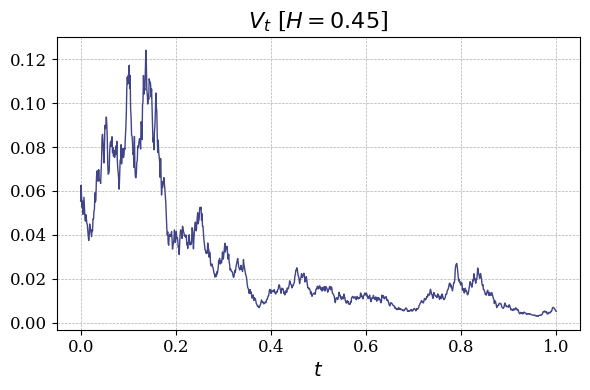

In [5]:
############################################
#   PART 4: Plots of the rBergomi model    #
#   and the Terminal wealth                #
############################################

# Volatility plot
title_font = {'family': 'serif', 'weight': 'normal', 'size': 16}
label_font = {'family': 'serif', 'weight': 'normal', 'size': 14}
tick_font = {'family': 'serif', 'weight': 'normal', 'size': 12}
plt.figure(figsize=(6, 4))  
plt.plot(t, V, color='#414487FF', linestyle='-', linewidth=1, markeredgewidth=1, markeredgecolor='black')  
plt.title(r'$V_t$ [$H=0.45$]', fontdict=title_font) 
plt.xlabel(r'$t$', fontdict=label_font) 
#plt.ylabel('rBergomi volatility', fontdict=label_font)
plt.xticks(fontsize=12, fontname='serif', fontweight='normal')
plt.yticks(fontsize=12, fontname='serif', fontweight='normal')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout() 
plt.savefig('V_H_045.png',dpi=300)
plt.show() 




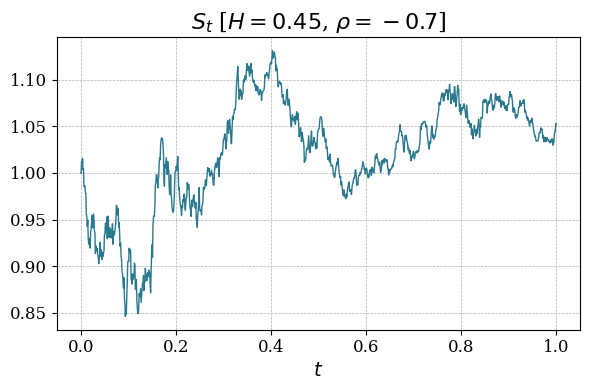

In [6]:
# Stock price plot
title_font = {'family': 'serif', 'weight': 'normal', 'size': 16}
label_font = {'family': 'serif', 'weight': 'normal', 'size': 14}
tick_font = {'family': 'serif', 'weight': 'normal', 'size': 12}
plt.figure(figsize=(6, 4))  
plt.plot(t, S, color='#2A788EFF', linestyle='-', linewidth=1, markeredgewidth=1, markeredgecolor='black')  
plt.title(r'$S_t$ [$H=0.45$, $\rho=-0.7$]', fontdict=title_font) 
plt.xlabel(r'$t$', fontdict=label_font) 
#plt.ylabel('rBergomi volatility', fontdict=label_font)
plt.xticks(fontsize=12, fontname='serif', fontweight='normal')
plt.yticks(fontsize=12, fontname='serif', fontweight='normal')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout() 
plt.savefig('S_H_045_rho_neg.png',dpi=300)

plt.show() 


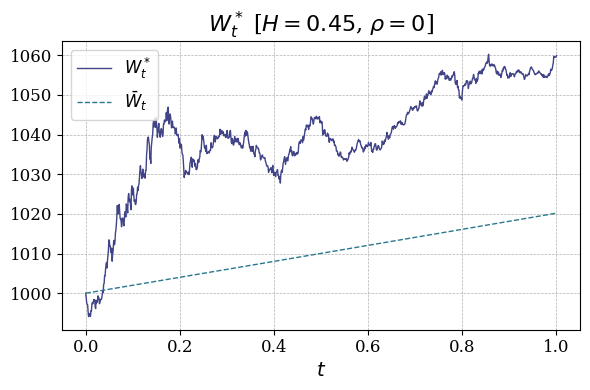

In [12]:
# Terminal wealth plot
title_font = {'family': 'serif', 'weight': 'normal', 'size': 16}
label_font = {'family': 'serif', 'weight': 'normal', 'size': 14}
tick_font = {'family': 'serif', 'weight': 'normal', 'size': 12}
plt.figure(figsize=(6, 4))  
plt.plot(t, W, color='#414487FF', linestyle='-', linewidth=1, markeredgewidth=1, markeredgecolor='black', label=r'$W^*_t$')
plt.plot(t, Wbar, color='#2A788EFF', linestyle='--', linewidth=1, markeredgewidth=1, markeredgecolor='black',  label=r'$\bar{W}_t$')
plt.title(r'$W^*_t$ [$H=0.45$, $\rho=0$]', fontdict=title_font) 
plt.xlabel(r'$t$', fontdict=label_font) 
#plt.ylabel('rBergomi volatility', fontdict=label_font)
plt.xticks(fontsize=12, fontname='serif', fontweight='normal')
plt.yticks(fontsize=12, fontname='serif', fontweight='normal')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc='upper left', fontsize=12, frameon=True)
plt.tight_layout() 
plt.savefig('W_H_045.png',dpi=300)

plt.show()